# Construction d'un dataset biasé
- Constructionun d'un dataset 
- Les représentent 100 k demandeurs d'emploi. 
- Répartition homme femme de 70/30. 
- La probabilité de trouver un emploi après 3 mois est de 9 % pour les hommes et de 5 % pour les femmes.

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [2]:
n_pop = 100000
p_male = 0.7

p_job_male, p_job_female = 0.09, 0.05

In [3]:
gender = np.random.choice(['male', 'female'], size=n_pop, p=[p_male, 1 - p_male])

df = pd.DataFrame({'gender' : gender})

df.loc[df.gender == 'male', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'male']), p=[p_job_male, 1 - p_job_male])
df.loc[df.gender == 'female', 'found_job'] = np.random.choice([1, 0], size=len(df.loc[df.gender == 'female']), p=[p_job_female, 1 - p_job_female])

df['found_job'] = df['found_job'].astype(int)

Répartition des sexes

In [12]:
df.pivot_table(index='gender', columns='found_job', aggfunc='size')

found_job,0,1
gender,,
female,28551,1456
male,63719,6274


In [15]:
print(df.head(10))

   gender  found_job
0  female          0
1    male          0
2  female          0
3    male          0
4  female          1
5  female          0
6    male          0
7  female          0
8    male          0
9    male          0


Attribuer des âges à chaque demandeur d'emploi en échantillonnant à partir d'une distribution gaussienne (moyenne de mu et un écart type de sigma)

- On va faire deux distribution gaussiénne : une pour les demandeurs d'emploi qui trouvent un emploi, et une pour les demandeurs d'emploi qui ne trouvent pas d'emploi. 
- La répartition par âge des demandeurs d'emploi qui trouvent un emploi ont une moyenne plus faible (ceci pour refléter le fait qu'il est plus facile pour les jeunes demandeurs d'emploi de trouver du travail.)

In [4]:
mu_job, sigma_job = 45, 8
mu_no_job, sigma_no_job = 55, 10

In [5]:
df.loc[df.found_job == 1, 'age'] = np.floor(np.random.normal(mu_job, sigma_job, len(df.loc[df.found_job == 1])))
df.loc[df.found_job == 0, 'age'] = np.floor(np.random.normal(mu_no_job, sigma_no_job, len(df.loc[df.found_job == 0])))

df['age'] = df['age'].astype(int)

In [6]:
df.groupby('found_job').mean().round(1)

,age
found_job,
0,54.5
1,44.5


- Créer la classe socio-économique (A, B ou C) , pour désigner respectivement les classes supérieure, moyenne et inférieure.
- Comme pour la répartition par âge, nous pouvons échantillonner à partir de deux distributions : une pour les demandeurs d'emploi qui trouvent un emploi, et une pour les demandeurs d'emploi qui ne trouvent pas d'emploi. 
- Pour les poids des distributions: 
    - Les demandeurs d'emploi qui trouvent un emploi ont tendance à appartenir aux classes socio-économiques supérieures, 
    - Les demandeurs d'emploi qui ne trouvent pas d'emploi ont tendance à appartenir aux classes socio-économiques inférieures.

In [7]:
class_set = ['A', 'B', 'C']
class_wt_job = [0.4, 0.4, 0.2]
class_wt_no_job = [0.2, 0.3, 0.5]

In [8]:
df.loc[df.found_job == 1, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 1]), p=class_wt_job)
df.loc[df.found_job == 0, 'class'] = np.random.choice(class_set, size=len(df.loc[df.found_job == 0]), p=class_wt_no_job)

In [9]:
df.pivot_table(index='class', columns='found_job', aggfunc='size')

found_job,0,1
class,,
A,18420,3107
B,27701,3132
C,46061,1579


Afficher la dataframe

In [23]:
print(df)

       gender  found_job  age class
0      female          0   61     C
1        male          0   35     B
2      female          0   55     C
3        male          0   44     B
4      female          1   54     B
...       ...        ...  ...   ...
99995  female          0   30     C
99996    male          0   58     B
99997    male          0   55     C
99998    male          0   38     C
99999  female          0   44     C

[100000 rows x 4 columns]


Verifier la réparttion du déquilibrage definit lors des étapes précedentes

In [10]:
agg_gender = df[['gender', 'found_job']].groupby('gender').mean()
print(agg_gender.round(3))

        found_job
gender           
female      0.049
male        0.091


- Tracer le biais definit par un barplot
- Sur le meme graphique tracer une ligne en pointillée qui correspond à la probabilité globale de trouver un emploi

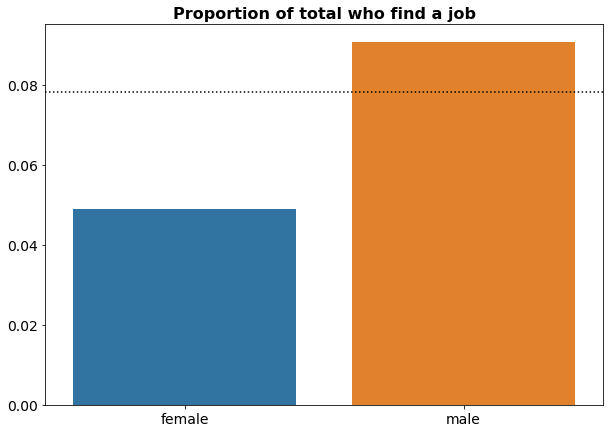

In [12]:
mean_found_job = df['found_job'].mean()

fig, ax1 = plt.subplots(figsize=(10, 7))
sns.barplot(x=agg_gender.index, y=agg_gender.found_job, ax=ax1).\
set_title('Proportion of total who find a job', fontsize=16, fontweight='bold')
ax1.axhline(mean_found_job, color='k', linestyle=':')
ax1.set(xlabel='', ylabel='')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

Quelle est la valeur de ce seuil

In [14]:
print(mean_found_job.round(3))

0.078


Expliquer briévement la signification de ce seuil

==> Les hommes ont une probabilité supérieure à la moyenne de trouver un emploi, tandis que les femmes ont une probabilité inférieure à la moyenne de trouver un emploi.

# Introduction de la librairie AIF360

Conversion du dataset au format aif360: 
- Faite du OnhotEncoding sur les variables sexe et classe

In [16]:
df_onehot = pd.concat([df[['found_job', 'age']], pd.get_dummies(df[['gender', 'class']])], axis=1)


- On va considérer une labelisation binaire (soit le demandeur trouven un emploi, soit il n'en trouve pas).
- Nous convertissons donc les données en un BinaryLabelDataset, 
- Nommer cet attribut binaire par exemple (found_job) 
- Pour létude du biais nous allos garder seulement l'attribut gender_female, donc nous supprimons la colonne gender_male car elle présente entre autre des informations redondantes.

In [17]:
df_aif = BinaryLabelDataset(df=df_onehot.drop('gender_male', axis=1), label_names=['found_job'], protected_attribute_names=['gender_female'])
print(df_aif)

               instance weights features                                      \
                                         protected attribute                   
                                     age       gender_female class_A class_B   
instance names                                                                 
0                           1.0     61.0                 0.0     0.0     0.0   
1                           1.0     22.0                 1.0     0.0     1.0   
2                           1.0     54.0                 0.0     0.0     1.0   
3                           1.0     59.0                 0.0     1.0     0.0   
4                           1.0     37.0                 1.0     0.0     0.0   
...                         ...      ...                 ...     ...     ...   
99995                       1.0     56.0                 0.0     0.0     0.0   
99996                       1.0     61.0                 0.0     0.0     0.0   
99997                       1.0     59.0

Definir les préviléges des groupes (0/1) de la colonne gender_female

In [22]:
privileged_group = [{'gender_female': 0}]
unprivileged_group = [{'gender_female': 1}]

Diviser le dataset en un ensemble de test, de train et de validation 

In [23]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(50000, 5), (30000, 5), (20000, 5)]


On va maintenant choisir une fairness metric et l'appliquer sur l'ensemble du dataset

Cette metrique fait référence aux diverses tentatives de correction des biais algorithmiques dans les processus de décision automatisés basés sur des modèles d'apprentissage automatique.

Il existe différentes mesures de fairness dans aif360, mais celle sur laquelle nous nous concentrerons est la disparate ipact (DI). Il s'agit de la probabilité de succès étant donné que le demandeur d'emploi est non privilégié (femme),divisée par la probabilité de succès étant donné que le demandeur d'emploi est privilégié (homme). Nous reformulons cela en 1 - min(DI, 1/DI), puisque DI peut être supérieur à 1, ce qui signifierait que le groupe privilégié est désavantagé. Pour notre indice de référence d'équité, nous exigeons que 1 - min(DI, 1/DI) < 0,2.

In [27]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)


def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)


print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.461


Cette valeur de 1 - min(DI, 1/DI) confirme que l'ensemble de données d'origine est biaisé. Si la valeur est de 0. Donc il n y a pas de biais. Ce n'est pas le cas ici

# Entrainner un modéle et mesurer le biais

- Choisir un logitique regression comme classifieur

In [33]:
def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale

In [34]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

- Notre objectif maintenant c'est de: 
    + Trouver la meilleur modélisation qui donne la meilleur accuracy (noter bien le seil associé et l'accuracy)
    + Calculer au fur et à mesure le biais

In [35]:
thresh_arr = np.linspace(0.01, 0.5, 100)


def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob


y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)


def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())


def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:, 1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind': thresh_arr_best_ind, \
                                'thresh_arr_best': thresh_arr_best, \
                                'best_bal_acc': best_bal_acc, \
                                'disp_imp_at_best_bal_acc': disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
    get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))



100%|██████████| 100/100 [00:06<00:00, 15.63it/s]

Threshold corresponding to best balanced accuracy: 0.084
Best balanced accuracy: 0.753
1-min(DI, 1/DI): 0.522


Expliquer le résultat obtenu

==> Cela montre que le seuil avec la meilleure précision est de 0,094. À ce seuil, notre métrique de précision (précision équilibrée) est de 0,753, mais notre métrique d'équité (1-min(DI, 1/DI)) est de 0,522, ce qui indique un biais. Nous pouvons tracer ces mesures de précision et d'équité sur une plage de seuils de classification :

+ On remarque aussi que meme avec la determination du meilleur seuil statistique et meilleur accuracy, il y a un biais. (calculé par le disparate impact)

- Dessiner les courbes suivantes:
    - Accuracy * Seuil
    - DI * Seuil

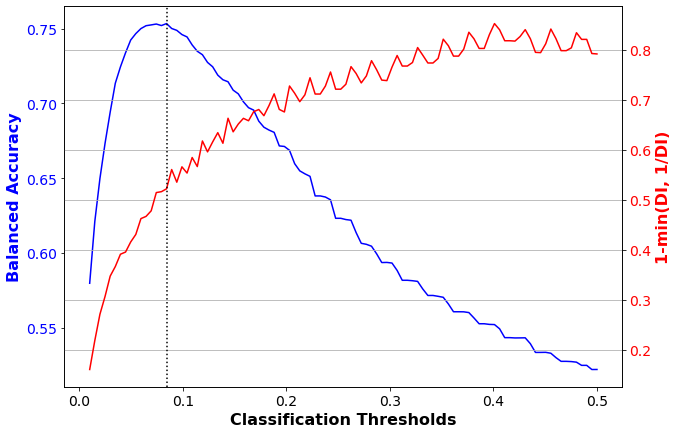

In [37]:

def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)


plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
                     '1-min(DI, 1/DI)', bal_acc_arr_orig, \
                     acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

Interpreter la signification des deux courbes

On vois sur la courbe que la meilleur accuracy trouvé est le pique en bleu, qui corresponde au seuil (Threshol associé de 0.084)
Dans la courbe rouge, on vois si on réequilibre à 0.084, le biais sera de 0.522, ce qui est un biais énorme


Completer alors les valeurs de nos 3 metriques : Accuracy, seuil, DI sur le jeu de test

In [38]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)


def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:, 1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred


dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model( \
    y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst, \
    thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.084
Best balanced accuracy: 0.748
1-min(DI, 1/DI): 0.511


Expliquer les résultats

==> Comme pour l'ensemble de données de validation, nous nous retrouvons avec une bonne précision, mais une mauvaise métrique de Fairness. Cela montre que si nous ne considérons que la précision (comme c'est souvent le cas dans de nombreuses organisations), nous nous retrouvons avec un modèle biasé.

# Calibrage des données

Pour Traiter le biais, On va dans un premier temps transformer notre jeu de donnée par la technique "Reweighing". Cela attribue des pondérations différentes aux différentes entités de la population pour garantir le fairness.

In [39]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

# Calcul du fairness metric sur la dataset transformé

In [42]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.0


Que remarquez-vous ?

==> Lorsque nous calculons la métrique d'équité sur l'ensemble de données transformé, nous constatons qu'il est équitable.

# Entrainer un modéle sur le dataset non-biaisé (équilibré)

Refaire un autre modéle sur le jeu de donnée transformé, et on noter l'ensemble des metriques. Utiliser le jeu de données de validation dans ce cas

In [43]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [44]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
    get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))


100%|██████████| 100/100 [00:04<00:00, 24.60it/s]

Threshold corresponding to best balanced accuracy: 0.079
Best balanced accuracy: 0.749
1-min(DI, 1/DI): 0.107


Expliquer le résultat

==> Cela montre que le seuil avec la meilleure précision est de 0,079. À ce seuil, notre métrique de précision (précision équilibrée) est de 0,749, et notre métrique d'équité (1-min(DI, 1/DI)) est de 0,107, ce qui n'indique aucun biais. 

Tracer l'ensemble de mesures précision et DI sur une plage de seuils de classification

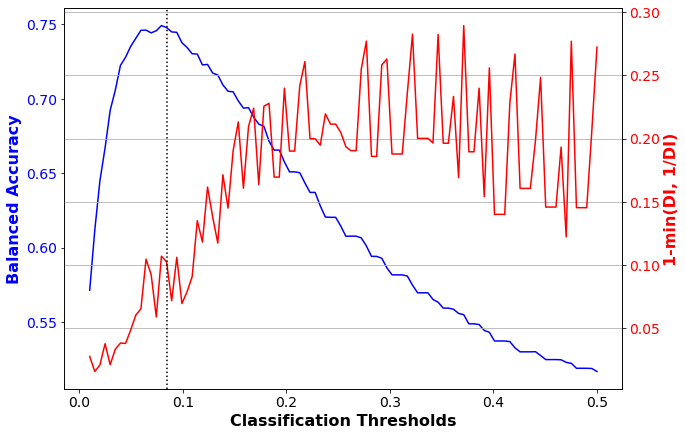

In [45]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

Interpreter la courbe

- On vois sur la courbe que la meilleur accuracy trouvé est le pique en bleu 0.749, qui corresponde au seuil (Threshol associé de 0.079)
- Dans la courbe rouge, on vois si on réequilibre à ce seuil 0.089, le biais sera de 0.107, ce qui est un biais acceptable

# Tester le model sur le dataset non-biaisé (equilibré)

Noter l'ensemble des mesures obtenues

In [47]:
y_test_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_tst)

dataset_pred_labels_transf, classified_metric_transf, metric_pred_transf = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_transf, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_transf.loc['thresh_arr_best', 0])

print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_transf).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_transf.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.079
Best balanced accuracy: 0.743
1-min(DI, 1/DI): 0.1


Interpreter le résultat

Comme pour l'ensemble de données de validation, nous nous retrouvons avec une bonne métrique de précision et de fairness. L'atténuation du biais a entraîné une légère détérioration de la précision (de 0,748 à 0,749), mais une amélioration considérable de l'équité (0,511 à 0,107). Cela montre que des modèles à la fois précis et justes peuvent être construits sur des données biaisées, à condition que l'atténuation des biais soit appliquée de manière appropriée.

# Conclusion

Nous avons vu ici comment un ensemble de données avec un biais historique entraînera des modèles construits dessus pour produire des résultats injustes. Dans notre scénario, plus de ressources seraient allouées aux hommes, car ils ont toujours été plus susceptibles de trouver un emploi. En effet, les techniques d'apprentissage automatique traditionnelles optimisent uniquement la précision, pas l'équité.Nous avons également vu qu'en appliquant des techniques simples d'atténuation des biais, nous pouvons supprimer le biais de l'ensemble de données et ainsi créer des modèles avec une précision comparable, mais des mesures d'équité bien meilleures. Ces techniques de détection et d'atténuation des biais sont très pertinentes pour toute organisation cherchant à automatiser la prise de décision sur les populations aux attributs protégés.